# Setup

First, we need to initialize the object (a Pertpy package internal dataset), and if the object isn't already preprocessed and/or clustered, perform those steps.

## Imports & Options

In [4]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr import Crispr
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np

# Options
print("\nAnalysis Functions\n\t" + "\n\t".join(list(pd.Series(
    [np.nan if "__" in x else x for x in dir(cr.ax)]).dropna())))
file = "perturb-seq"
pd.options.display.max_columns = 100

#  Set Arguments
kwargs_init = dict(assay="rna", assay_protein="adt",
                   col_sample_id="replicate",
                   col_gene_symbols="gene_symbol",  
                   col_cell_type="leiden", 
                   col_perturbed="perturbation", 
                   col_guide_rna="NT", 
                   col_num_umis=None,
                   kws_process_guide_rna=None,
                   col_condition="gene_target", 
                   key_control="NT", 
                   key_treatment="Perturbed")
target_gene_idents = ["NT","JAK2","STAT1","IFNGR1","IFNGR2", "IRF1"]
file_path = pt.dt.papalexi_2021()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Analysis Functions
	analyze_composition
	cluster
	clustering
	composition
	compute_distance
	find_marker_genes
	perform_augur
	perform_celltypist
	perform_differential_prioritization
	perform_gsea
	perform_mixscape
	perturbations


## Object

This code instantiates the CRISPR object, which is the main way of interacting with this package as an end-user.

This is more code than you would need in real life; it just ensures that certain public datasets are loaded from the source for various reasons.

In [14]:
self = Crispr(file_path, **kwargs_init)



<<< INITIALIZING CRISPR CLASS OBJECT >>>



<<< INITIALIZING CRISPR CLASS OBJECT >>>


Unused keyword arguments: {'kws_process_guide_rna': None}.

col_gene_symbols='gene_symbol'
col_cell_type='leiden'
col_sample_id='orig.ident'
col_batch='orig.ident'
col_condition='gene_target'
key_control='Control'
key_treatment='KO'

<<< LOADING OBJECT >>>


Cell Counts: Raw

20729


Gene Counts: Raw



 MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
      layers:	'counts'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guid

# Processing

We will just use defaults for the preprocessing arguments (very little filtering, consistent with the Pertpy tutorial for this object).

## Preprocess

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_counts', 'log_counts', 'n_genes'
    var: 'name'
    layers: 'counts'

Un-Used Keyword Arguments: {'assay_protein': None, 'col_batch': 'orig.ident', 'col_condition': 'gene_target', 'col_target_genes': 'gene_target', 'col_perturbed': 'perturbation', 'col_guide_rna': 'NT', 'col_num_umis': None, 'col_guide_split': 'guide_split'}




Cell Counts: Initial

20729


Gene Counts: Initial

gene_symbol 

 10 

               name
count        18649
unique       18649
top     AL627309.1
freq             1 



<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




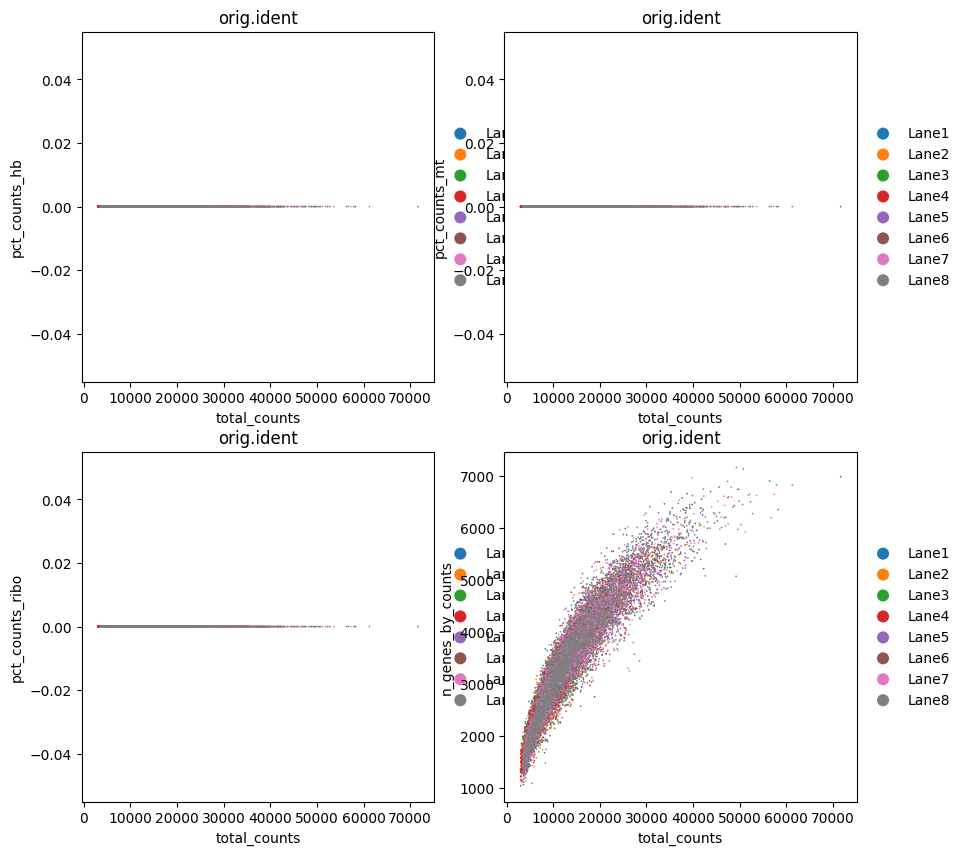

'NoneType' object has no attribute 'get_legend_handles_labels'
       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       18649.000000  18649.000000       18649.000000   
mean         3728.299051      0.711029           0.260142   
std          4962.527124      6.781103           0.471810   
min             0.000000      0.000000           0.000000   
25%           140.000000      0.007092           0.007066   
50%          1448.000000      0.078103           0.075203   
75%          5517.000000      0.357615           0.305729   
max         20729.000000    686.360107           6.532858   

       pct_dropout_by_counts  total_counts  log1p_total_counts  
count           18649.000000  1.864900e+04        18649.000000  
mean               82.014091  1.473893e+04            6.981041  
std                23.940022  1.405655e+05            2.579437  
min                 0.000000  0.000000e+00            0.000000  
25%                73.385113  1.470000e+02            4.997212

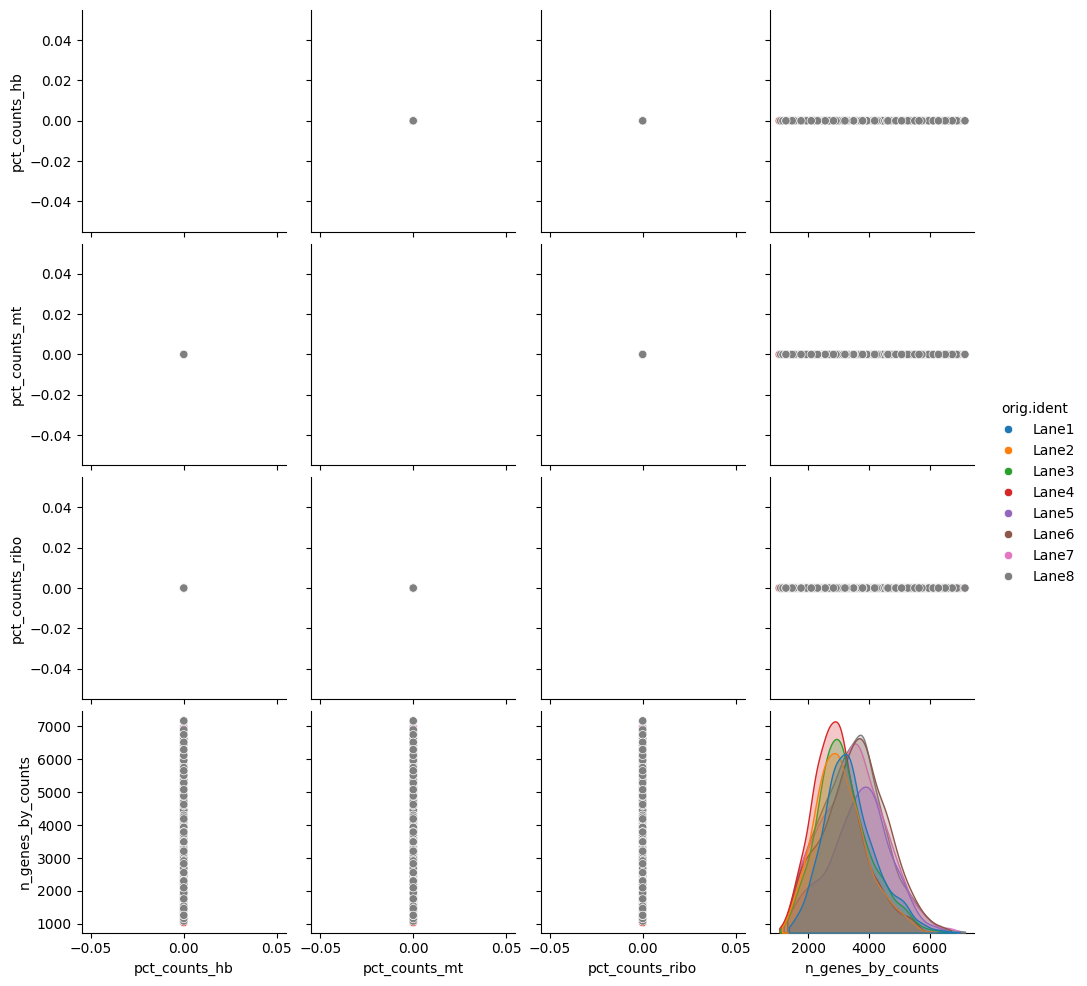

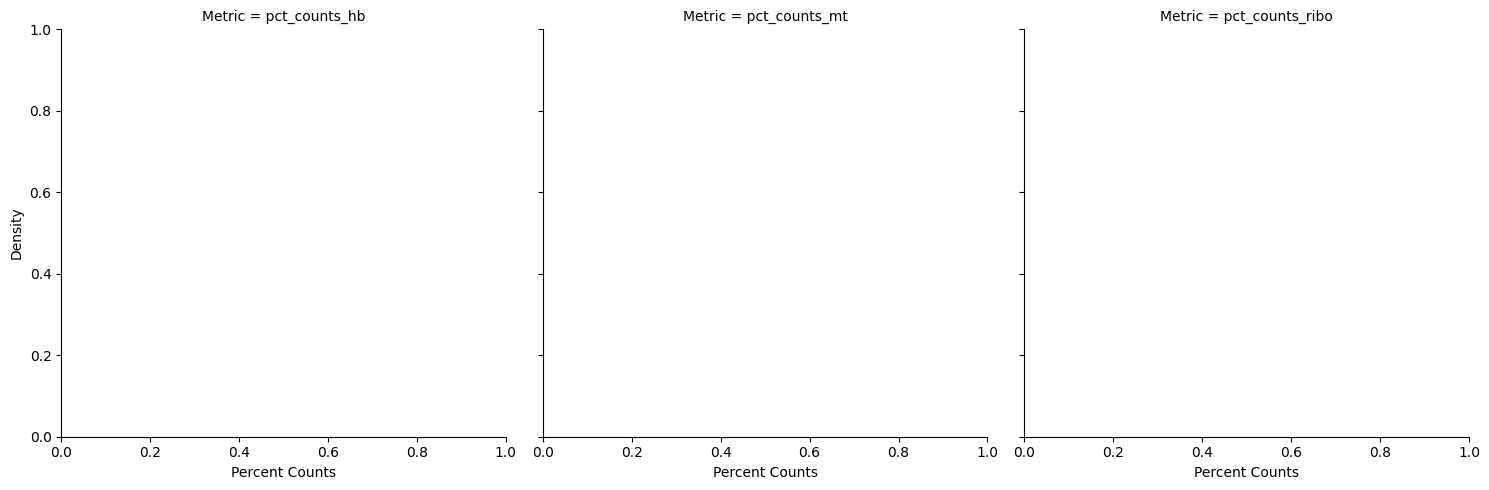

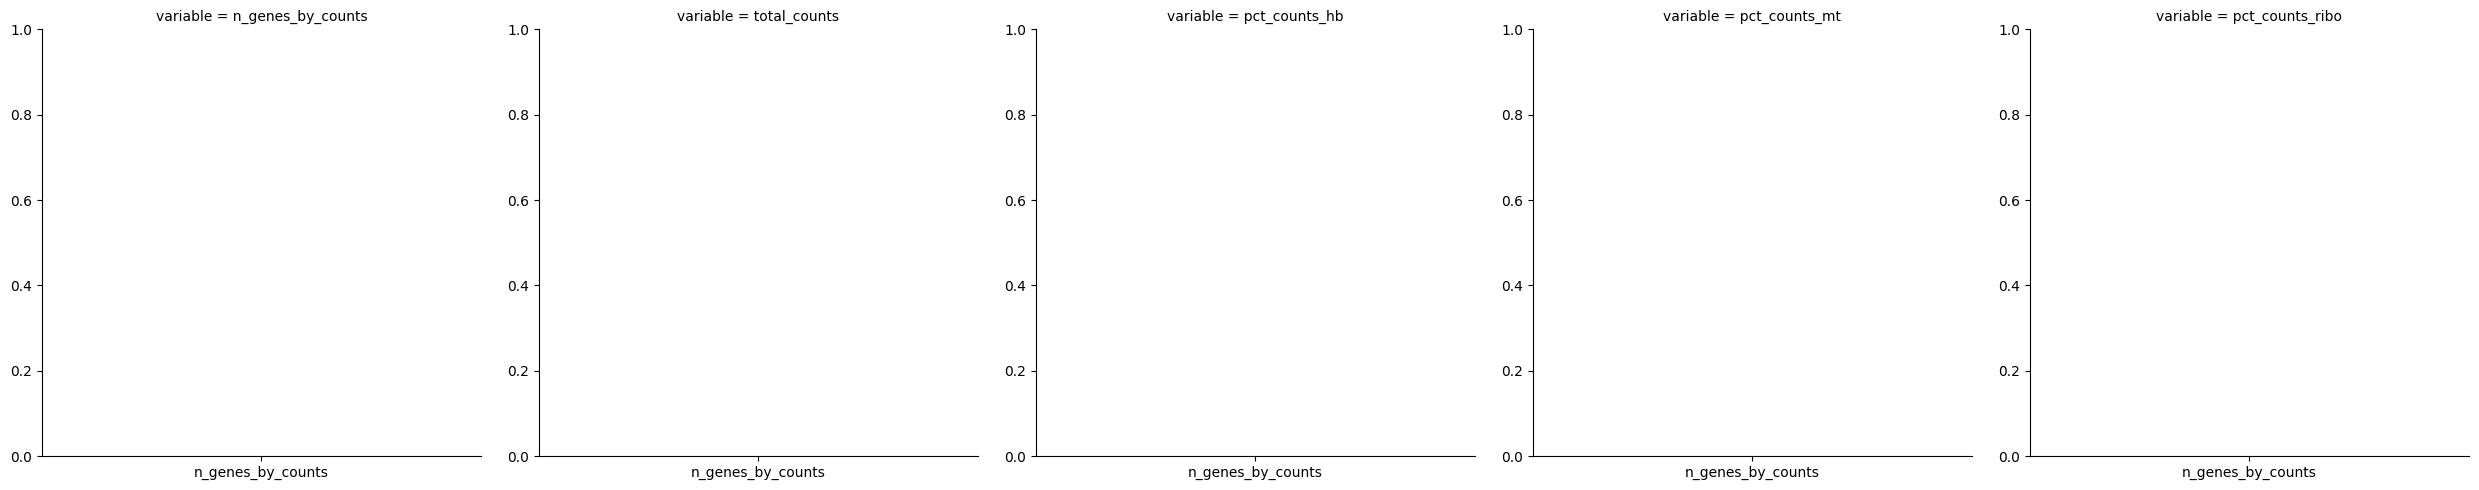

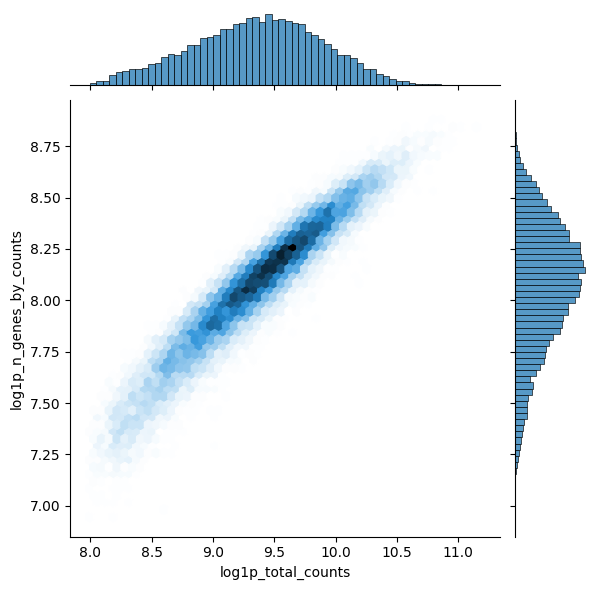

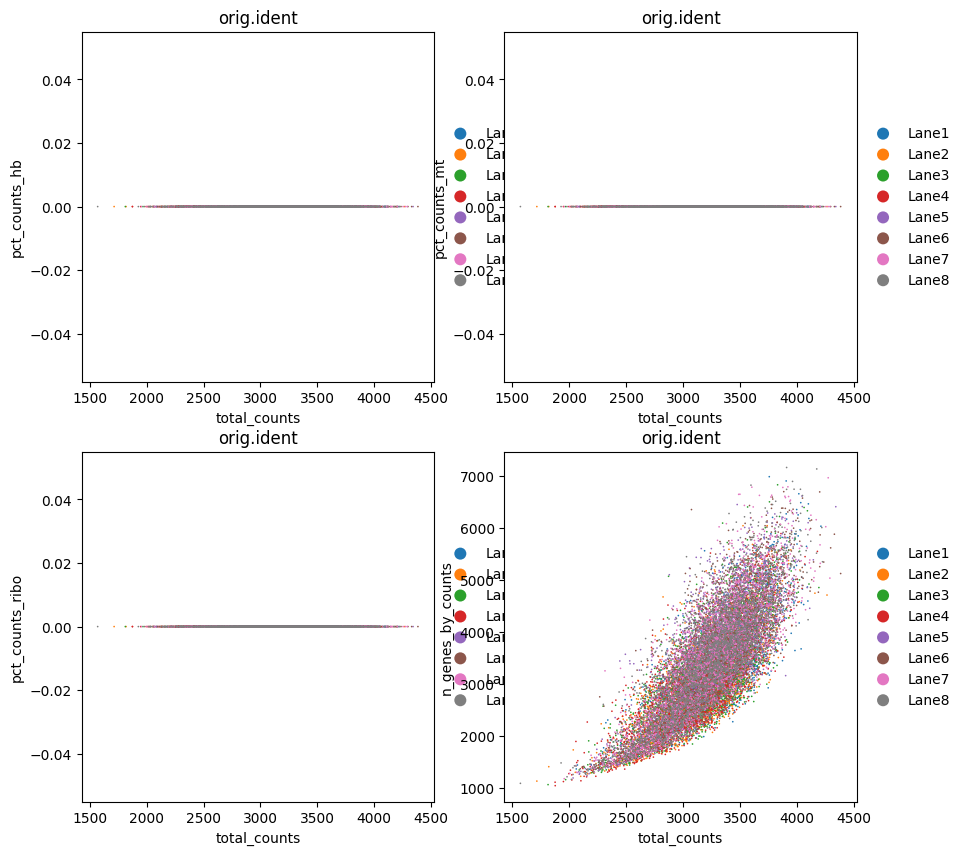

'NoneType' object has no attribute 'get_legend_handles_labels'
       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       18649.000000  18649.000000       18649.000000   
mean         3728.299051      0.172979           0.130414   
std          4962.527124      0.369702           0.215069   
min             0.000000      0.000000           0.000000   
25%           140.000000      0.003836           0.003828   
50%          1448.000000      0.040829           0.040017   
75%          5517.000000      0.176687           0.162703   
max         20729.000000      5.877882           1.928311   

       pct_dropout_by_counts   total_counts  log1p_total_counts         means  \
count           18649.000000   18649.000000        18649.000000  1.864900e+04   
mean               82.014091    3585.680176            6.292327  2.160319e-01   
std                23.940022    7663.555176            2.425707  4.163958e-01   
min                 0.000000       0.000000            0.000000

(AnnData object with n_obs × n_vars = 20729 × 18649
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
     var: 'name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'orig.ident_colors', 'log1p', 'hvg'
     layers: 'counts', 'log1p',
 {'qc_metrics': {'highly_expressed_genes': KeyError('gene_symbol')

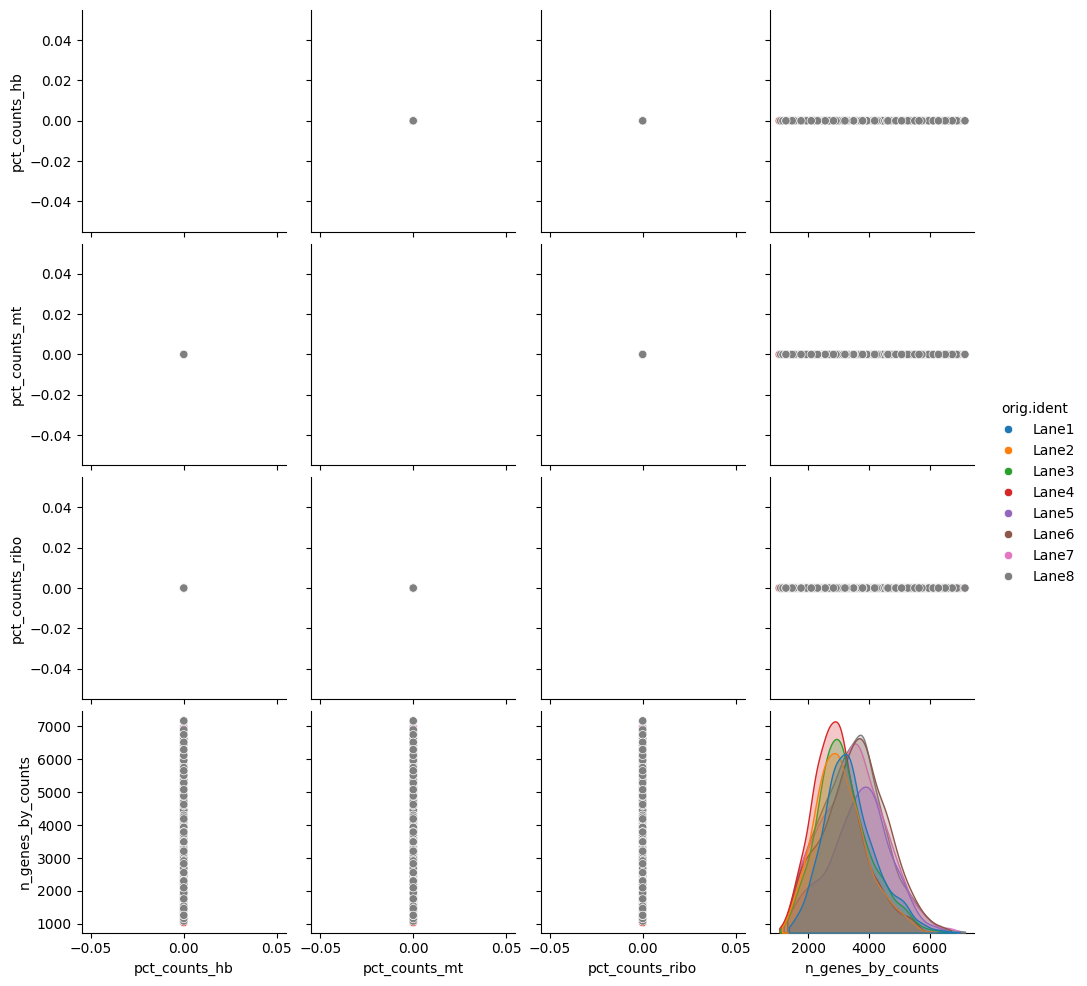

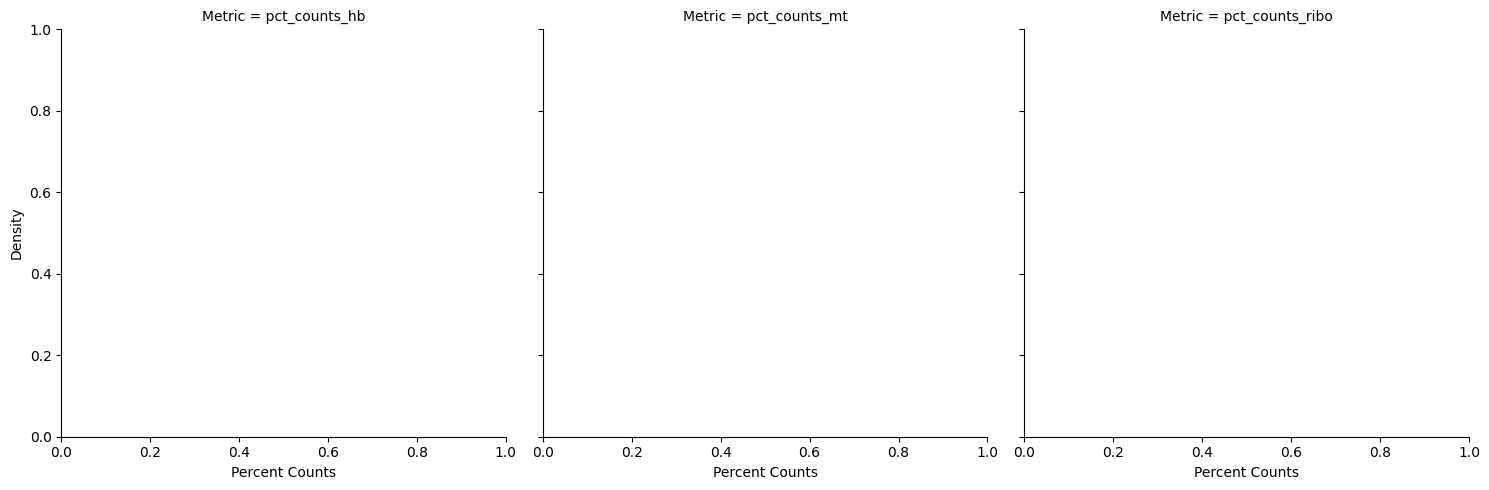

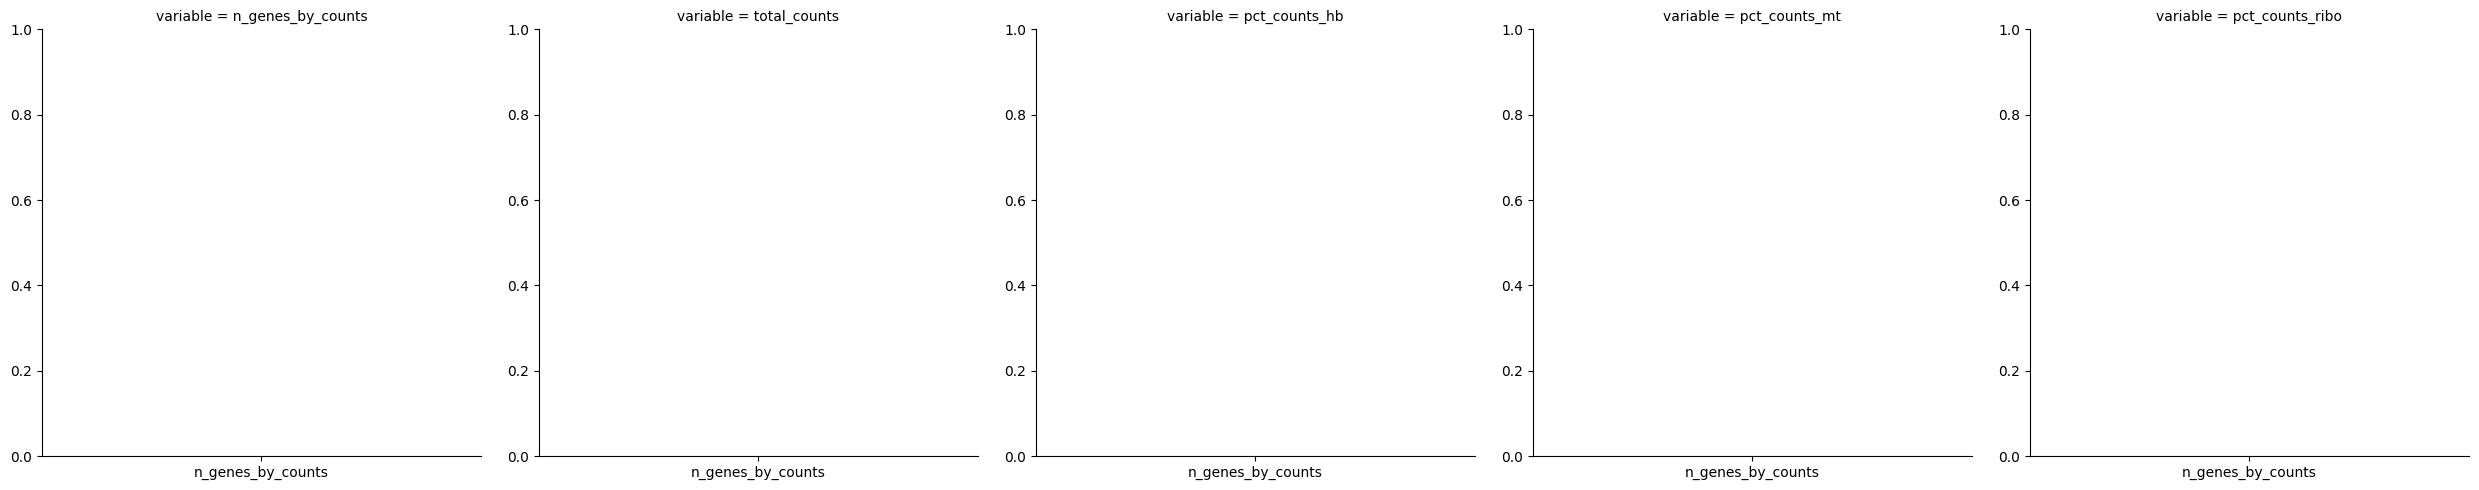

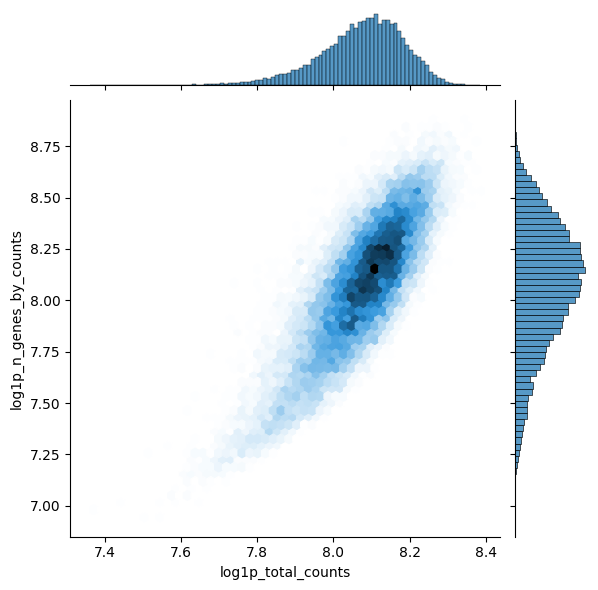

In [16]:
self.preprocess(kws_hvg=True, kws_scale=None, 
                regress_out=None)  # preprocessing

## Cluster

Un-used Keyword Arguments: {'assay': 'rna', 'col_gene_symbols': 'gene_symbol', 'col_cell_type': 'leiden', 'col_sample_id': 'orig.ident', 'col_batch': 'orig.ident', 'col_condition': 'gene_target', 'col_target_genes': 'gene_target', 'col_perturbed': 'perturbation', 'col_guide_rna': 'NT', 'col_num_umis': None, 'col_guide_split': 'guide_split', 'key_control': 'Control', 'key_treatment': 'KO', 'key_nonperturbed': 'NP'}


<<< PERFORMING PCA >>>

 {'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>



<<< EMBEDDING: UMAP >>>


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


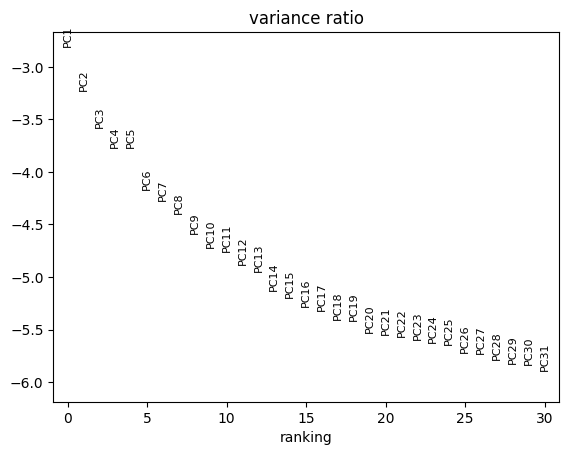

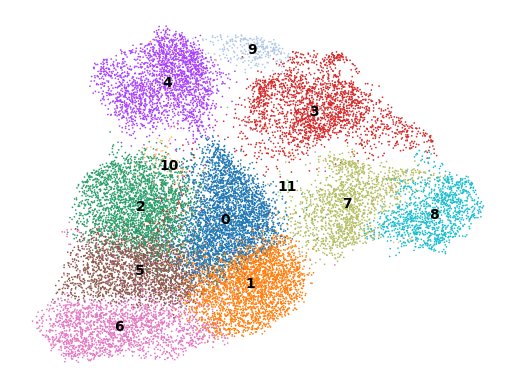

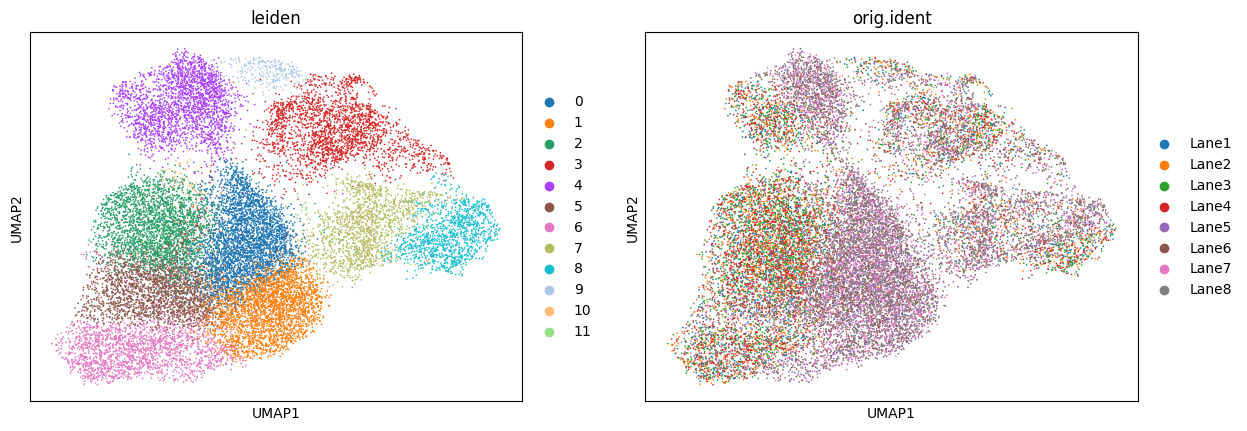

In [17]:
_ = self.cluster()
target_gene_idents = ["NT","JAK2","STAT1","IFNGR1","IFNGR2", "IRF1"]

# Analyses

The following examples concern CRISPR or other perturbation design-specific analyses.

## Guide RNA Counts/Percentage

In [ ]:
_ = self.get_guide_rna_counts(target_gene_idents=target_gene_idents)

## Mixscape: Cell-Level Perturbation Classification & Scoring

**Is a perturbed cell detectibly perturbed, and to what extent?** Mixscape first calculates the "**perturbation signature**" by determining which control condition cells most closely resemble each perturbed cell in terms of mRNA expression and then subtracts the control expression from that of the perturbed cells' (i.e., centers perturbed cells' gene expression on their control neighbors).

Then, it **identifies** and removes perturbed **cells with no detectible perturbation** (i.e., assigns them to predicted classes of perturbed versus not perturbed). You can then create visuals based on whether the cell is detectibly perturbed, "non-perturbed" (not detectibly perturbed), or control (no treatment). Optionally, you can visualize protein expression by this predicted class in certain multi-modal data.

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_ 

<u> __Features__ </u>  

- Plot targeting efficiency.
- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]``), you can specify a different column by passing `col_cell_type=<column name>` if you'd like.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. Specify as True to include all.
* **target_gene_idents**: The default layer of data used is "log1p." Remember that Mixscape centers cells on their control neighbors when considering whether to use centered and/or scaled data.
* **protein_of_interest**: If you have protein expression data (e.g., CITE-seq), you can specify a protein whose expression to plot against the perturbation conditions.

<u> __Output__ </u>  

Assuming your `Crispr` object is named "self":
- Targeting Efficiency: `self.figures["mixscape"]["targeting_efficiency"]`
- Differential Expression Ordered by Posterior Probabilities: `self.figures["mixscape"]["DEX_ordered_by_ppp_heat"]`
- Posterior Probabilities Violin Plot: `self.figures["mixscape"]["ppp_violin"]`
- Perturbation Scores: `self.figures["mixscape"]["perturbation_score"]`
- Perturbation Clusters (from LDA): `self.figures["mixscape"]["perturbation_clusters"]`

The above instructions are for accessing output via the object attributes. Assuming output is assigned to a variable `figs` (i.e., `figs = ` would replace the `_ = ` in the code below), replace `self.figures["mixscape"]` in the above code with `figs`.

<u> __Notes__ </u>  

- If `._columns["col_sample_id"]` is not None, perturbation scores will by default be calculated and/or plotted taking that into consideration (e.g., biological replicates) unless `col_split_by=False`. That argument can also be set to a different column name explicitly, in which case that specification will be used as the `col_split_by` argument in Pertpy Mixscape functions in place of sample ID.

#### Run Mixscape


Un-used Keyword Arguments: {'col_cell_type': 'leiden', 'col_gene_symbols': 'gene_symbol', 'col_sample_id': 'orig.ident', 'col_batch': 'orig.ident', 'col_condition': 'gene_target', 'col_num_umis': None, 'col_guide_split': 'guide_split', 'preprocessing': 'preprocessing', 'perturbation': 'X_pert', 'unnormalized': 'unnormalized', 'norm_total_counts': 'norm_total_counts', 'log1p': 'log1p', 'unscaled': 'unscaled', 'scaled': 'scaled', 'unregressed': 'unregressed', 'counts': 'counts', 'layer_perturbation': 'X_pert'}



<<< CALCULATING PERTURBATION SIGNATURE >>>

<<< RUNNING MIXSCAPE ROUTINE >>>


... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: JAK2 NP, JAK2 Perturbed, NT
var_group_labels: NT


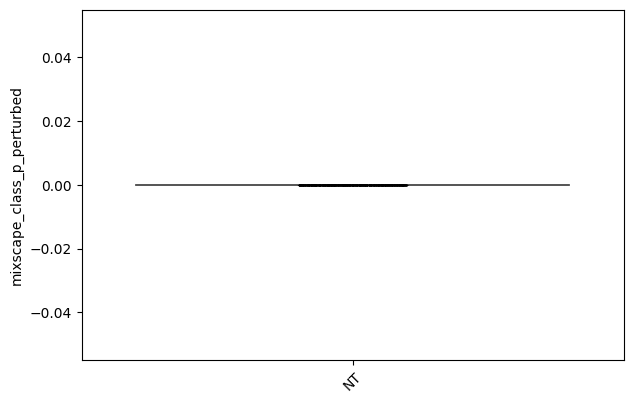

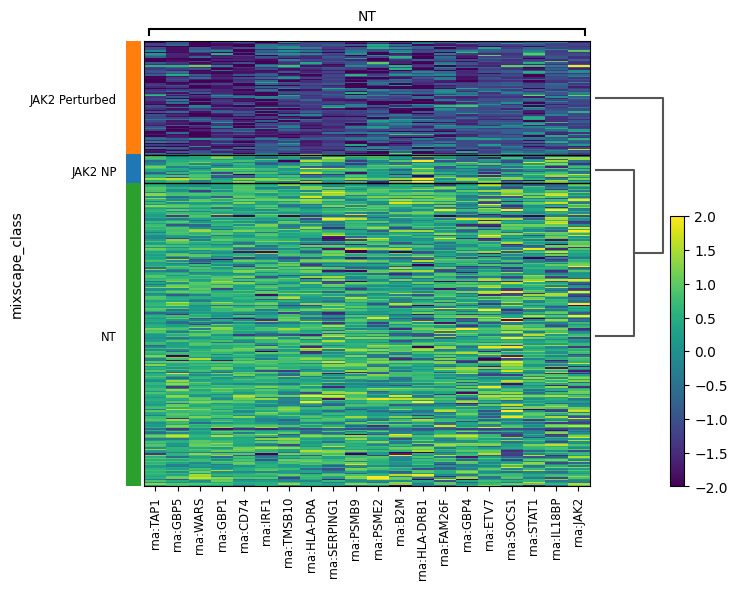

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: NT, STAT1 NP, STAT1 Perturbed
var_group_labels: NT


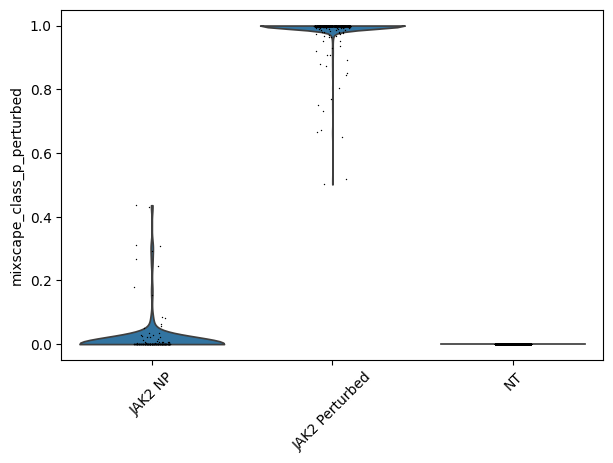

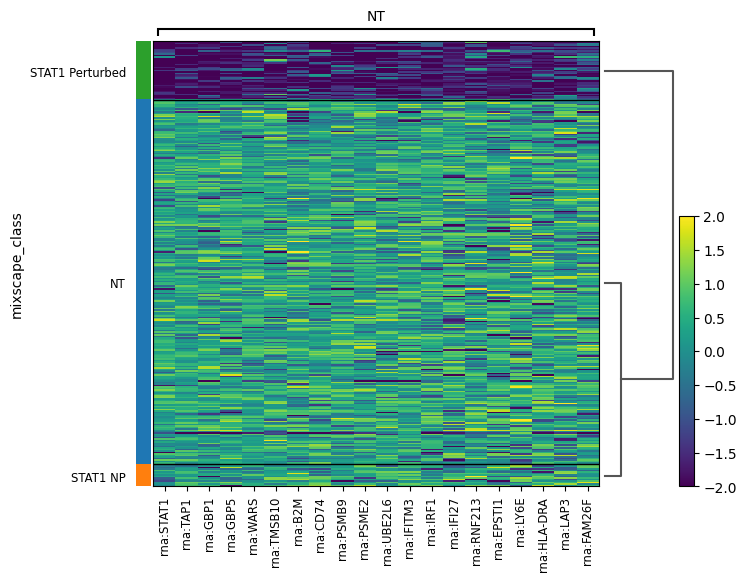

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: IFNGR1 NP, IFNGR1 Perturbed, NT
var_group_labels: NT


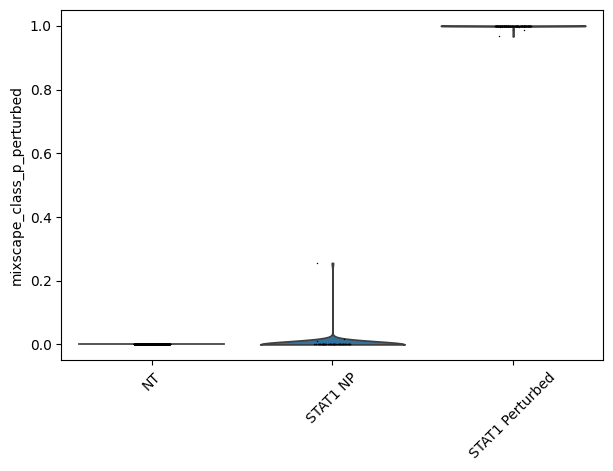

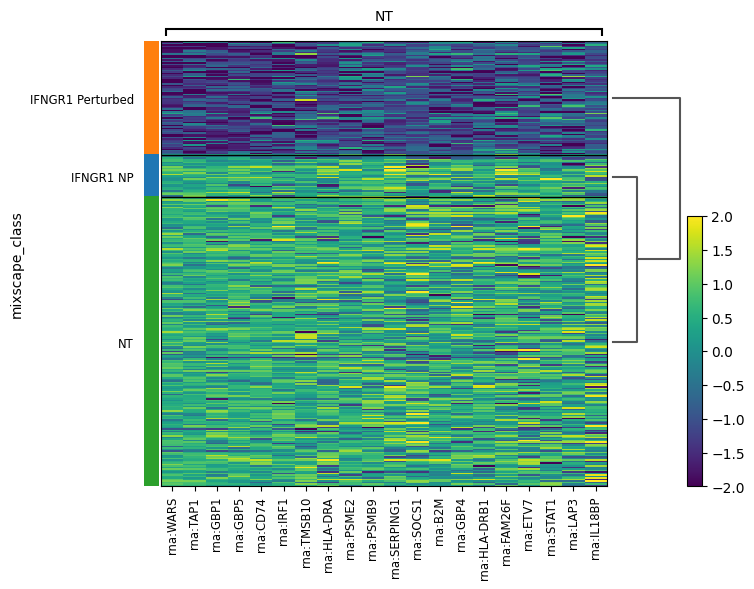

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: IFNGR2 NP, IFNGR2 Perturbed, NT
var_group_labels: NT


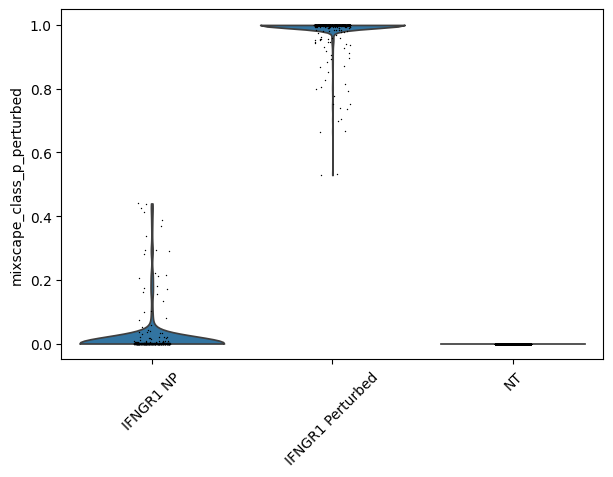

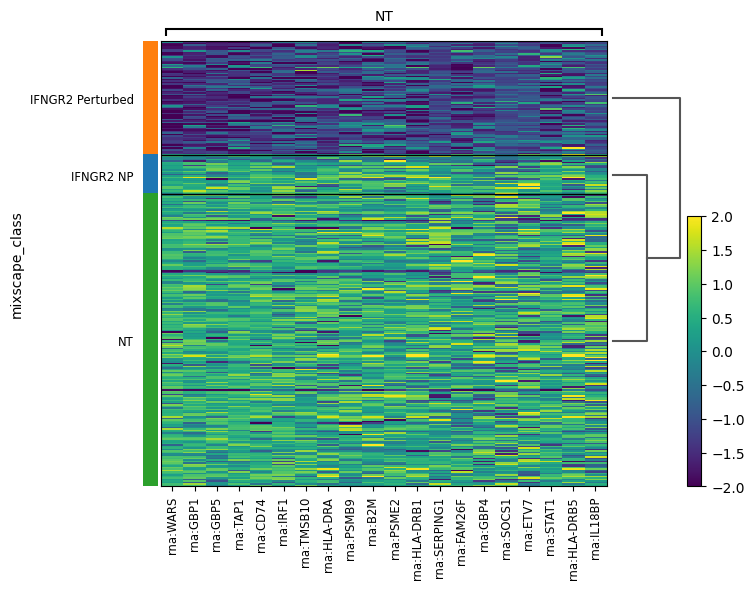

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: IRF1 NP, IRF1 Perturbed, NT
var_group_labels: NT


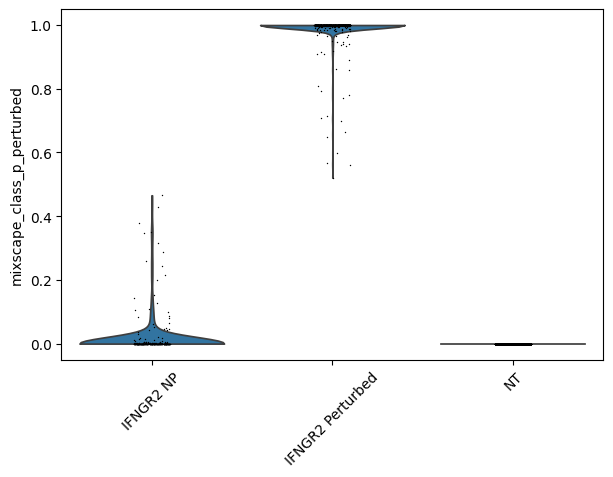

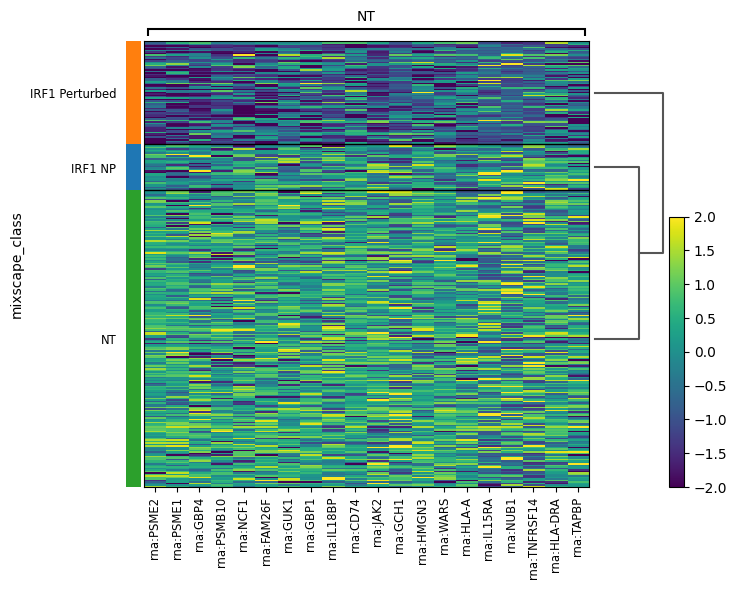

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


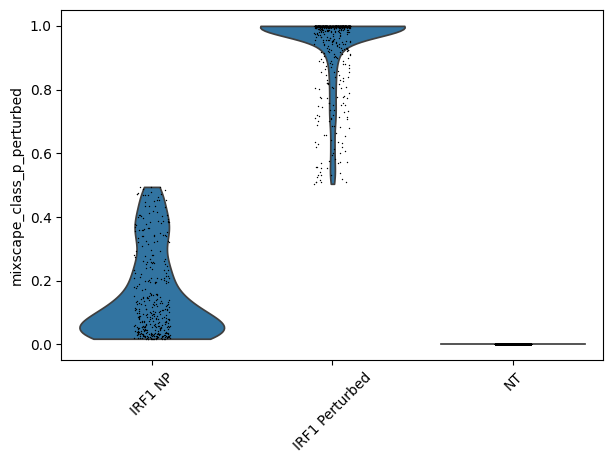

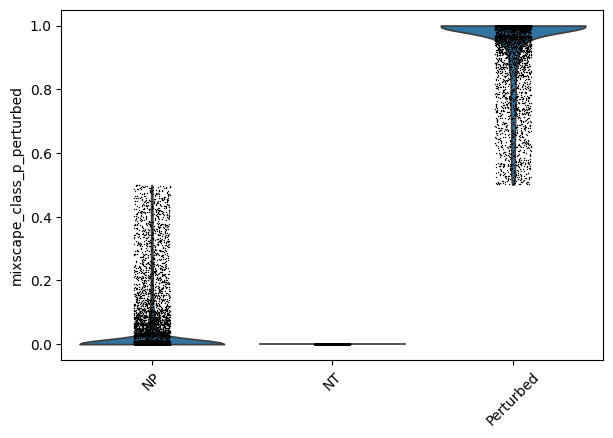

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


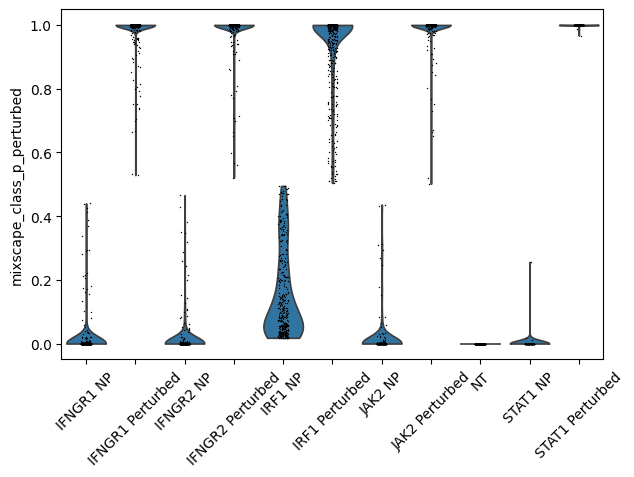

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


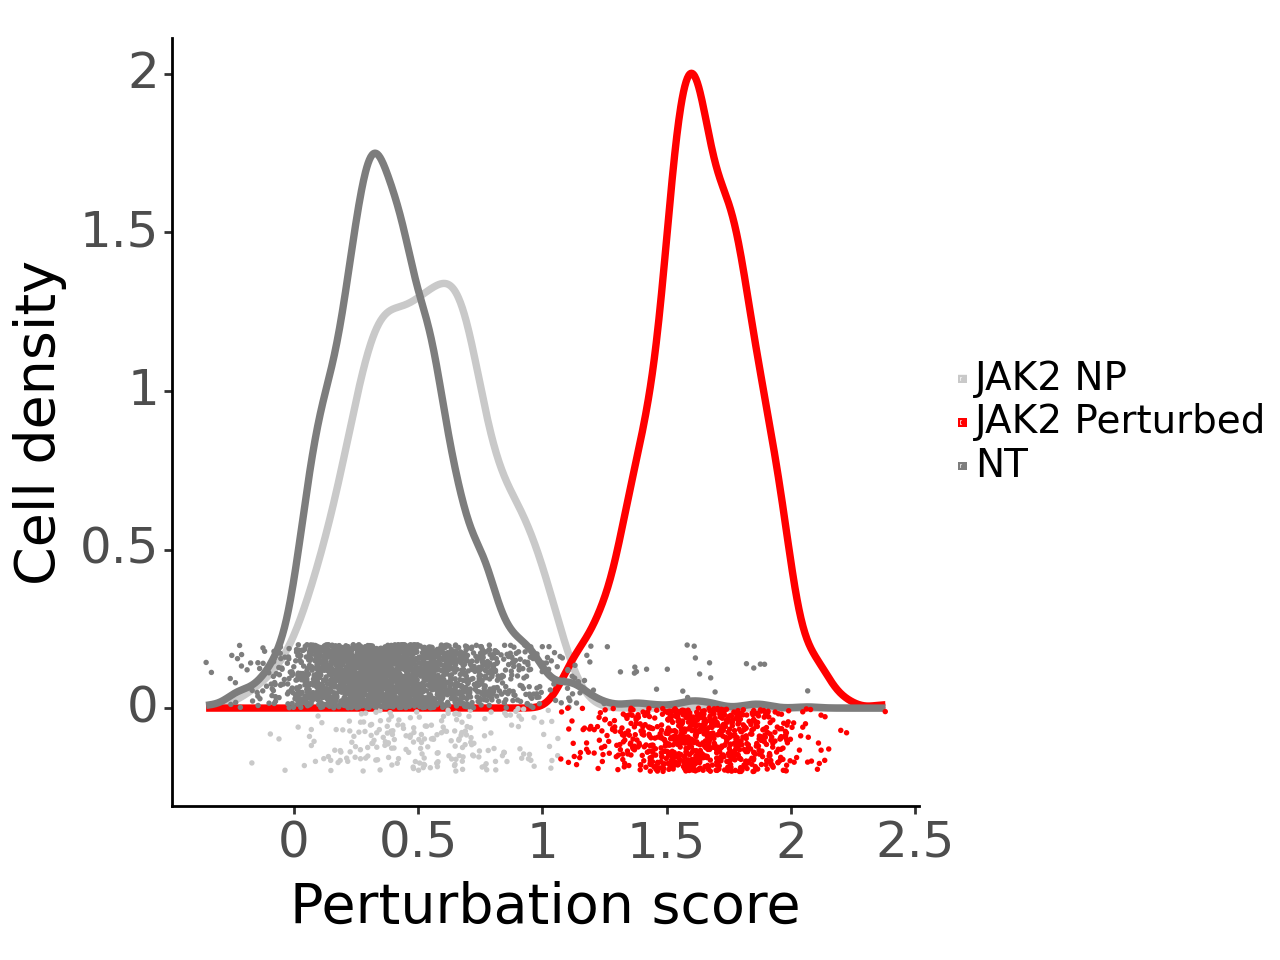

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


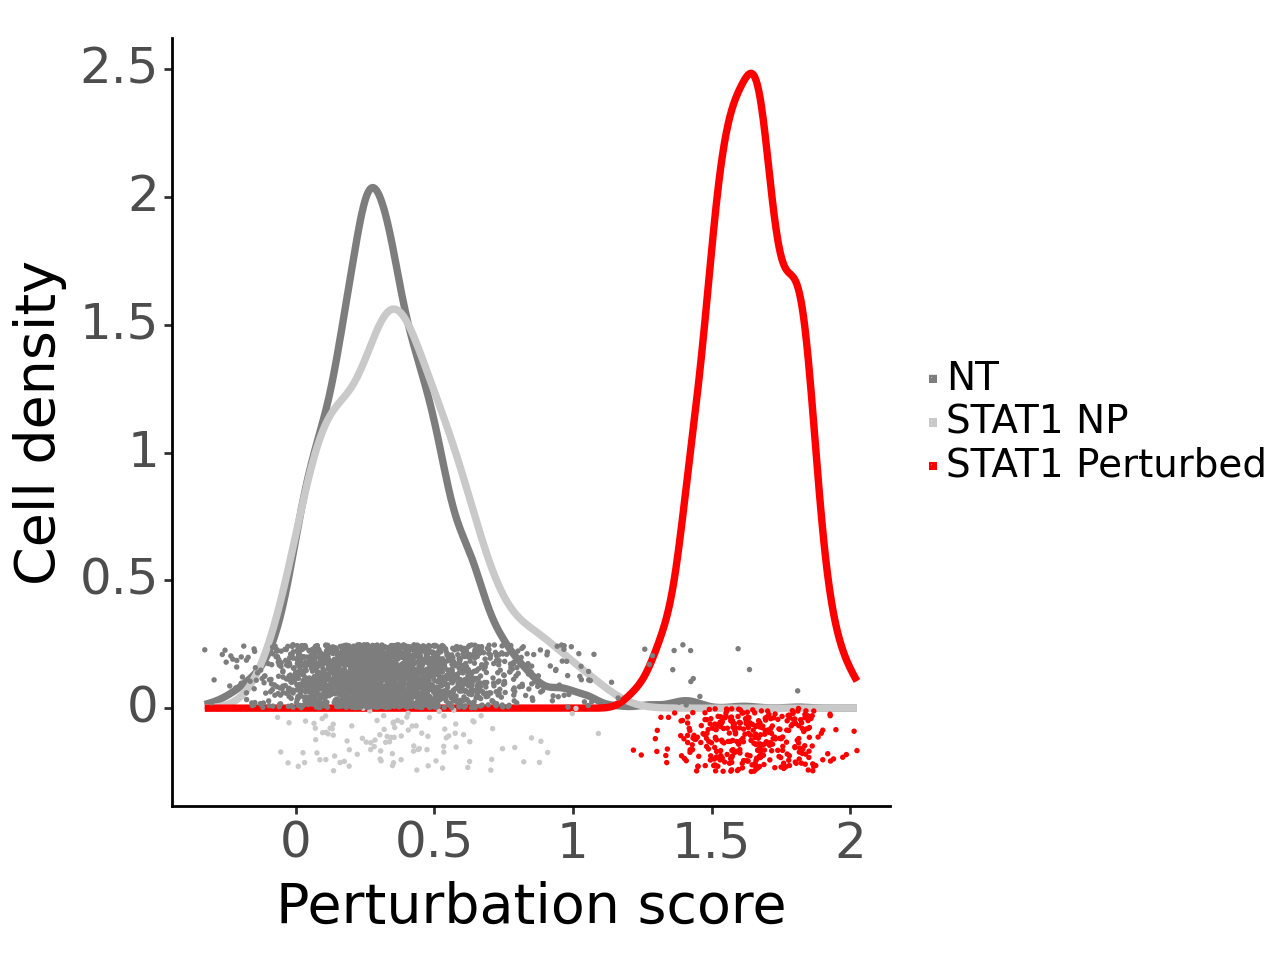

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


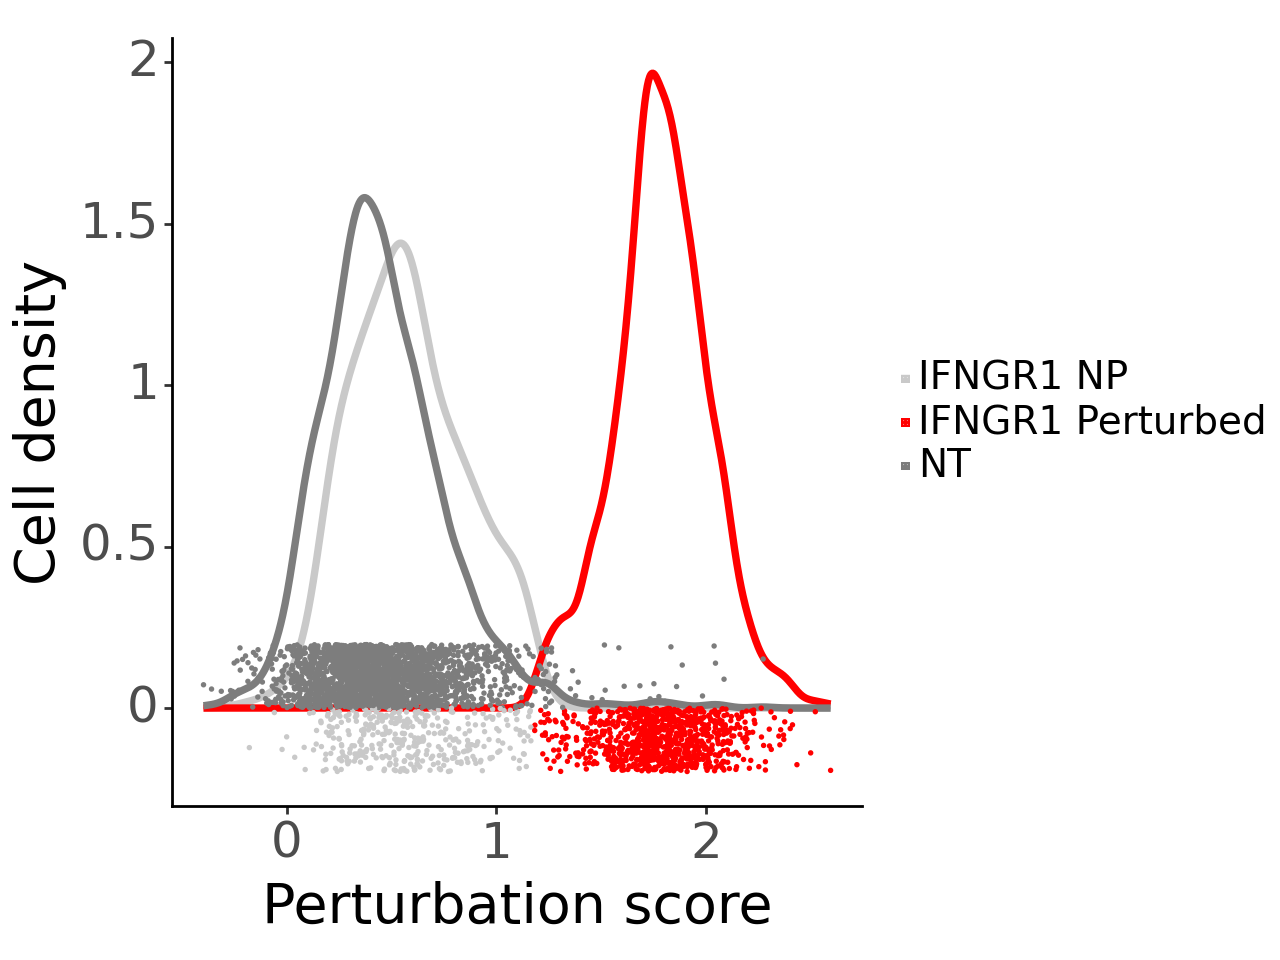

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


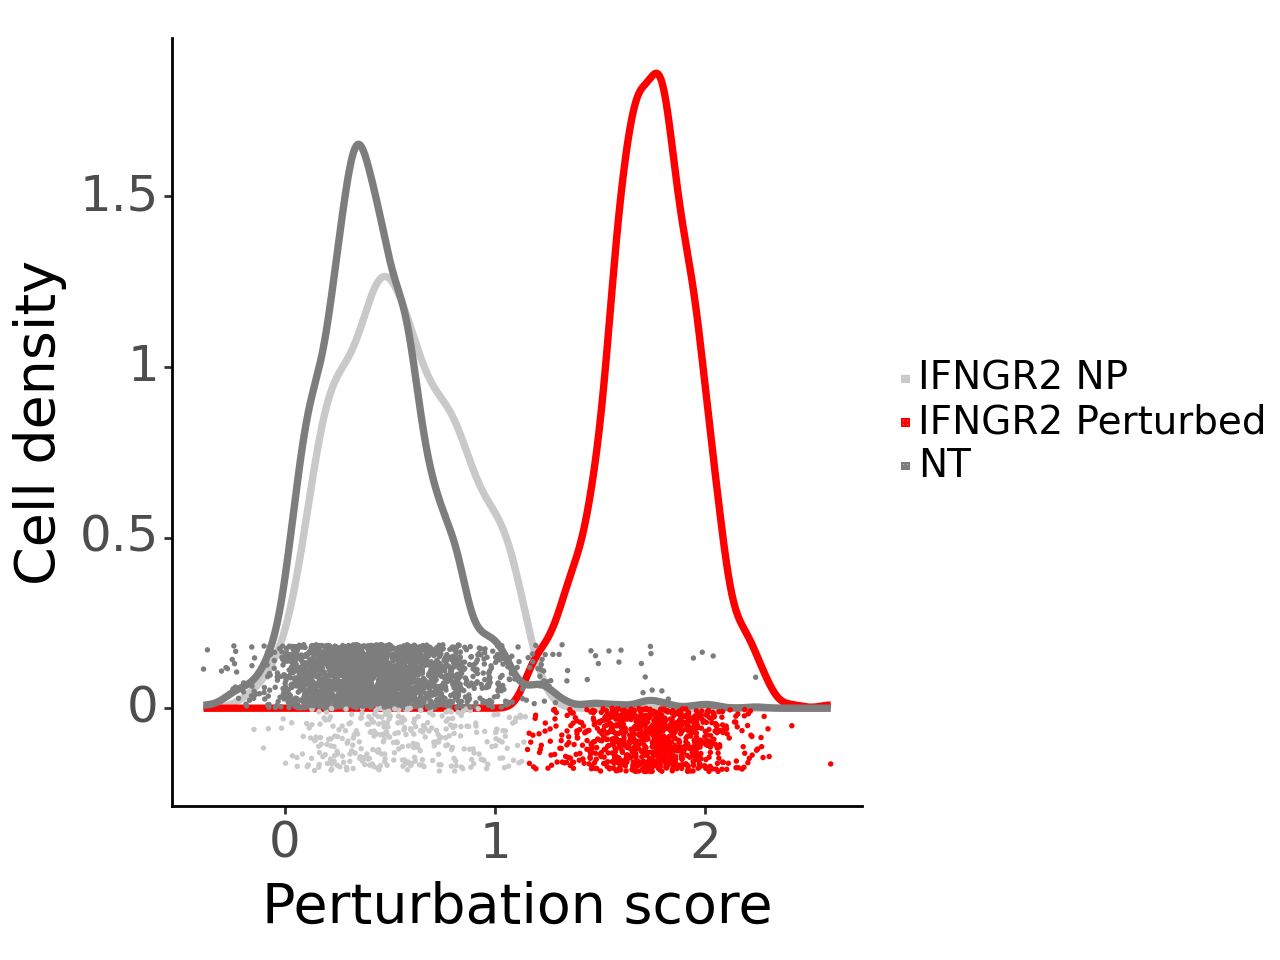

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


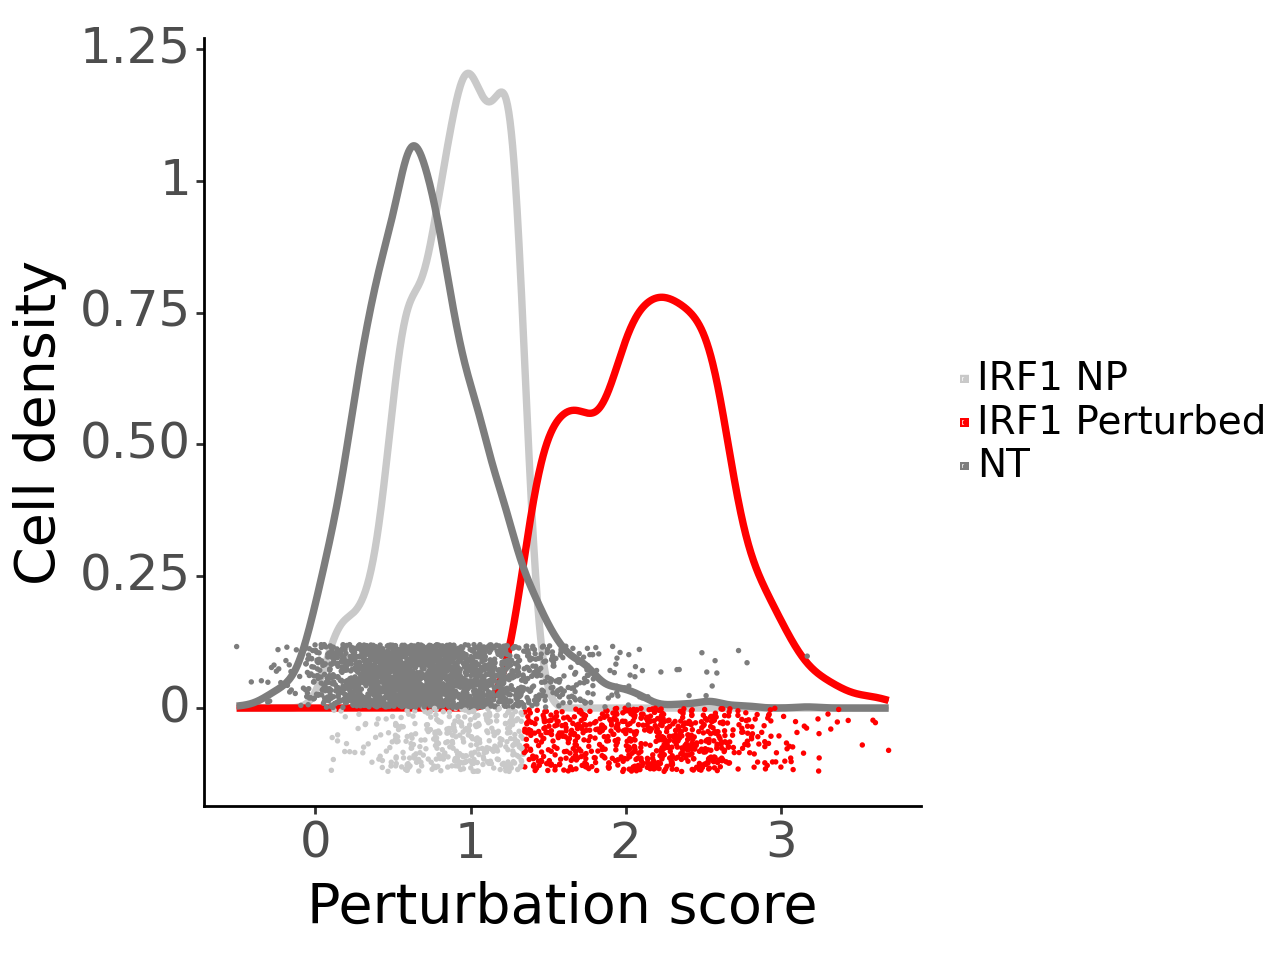

KeyError: 'targeting_efficiency'

In [27]:
_ = self.run_mixscape(target_gene_idents=target_gene_idents,
                      protein_of_interest="PDL1")

#### Create Different Mixscape Plots

If you want to re-create mixscape **plots with <u> different target genes and/or proteins of interest**</u> later, you can use `self.plot_mixscape(<ONE OR MORE TARGET GENES>)`. If you want a different color for the perturbation score curves, specify `color=` in that method.

In [ ]:
tgis = pd.Series(self.rna.uns["mixscape"].keys()).sample(1)
_ = self.plot_mixscape(tgis, color="red")